In [1]:
import os
import pandas as pd
from kaggle.competitions import nflrush
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
import lightgbm as lgb
import gc
import pickle
import tqdm
import category_encoders
import seaborn as sns
pd.set_option("display.max_columns",1000)

In [2]:
env = nflrush.make_env()

In [3]:
train_df = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2020/train.csv', low_memory=False)

In [4]:
train_df.head(3)

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,Season,YardLine,Quarter,GameClock,PossessionTeam,Down,Distance,FieldPosition,HomeScoreBeforePlay,VisitorScoreBeforePlay,NflIdRusher,OffenseFormation,OffensePersonnel,DefendersInTheBox,DefensePersonnel,PlayDirection,TimeHandoff,TimeSnap,Yards,PlayerHeight,PlayerWeight,PlayerBirthDate,PlayerCollegeName,Position,HomeTeamAbbr,VisitorTeamAbbr,Week,Stadium,Location,StadiumType,Turf,GameWeather,Temperature,Humidity,WindSpeed,WindDirection
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,496723,Eric Berry,29,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-0,212,12/29/1988,Tennessee,SS,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2495116,Allen Bailey,97,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,288,03/25/1989,Miami,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2495493,Justin Houston,50,2017,35,1,14:14:00,NE,3,2,NE,0,0,2543773,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",left,2017-09-08T00:44:06.000Z,2017-09-08T00:44:05.000Z,8,6-3,270,01/21/1989,Georgia,DE,NE,KC,1,Gillette Stadium,"Foxborough, MA",Outdoor,Field Turf,Clear and warm,63.0,77.0,8,SW


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509762 entries, 0 to 509761
Data columns (total 49 columns):
GameId                    509762 non-null int64
PlayId                    509762 non-null int64
Team                      509762 non-null object
X                         509762 non-null float64
Y                         509762 non-null float64
S                         509762 non-null float64
A                         509762 non-null float64
Dis                       509762 non-null float64
Orientation               509744 non-null float64
Dir                       509748 non-null float64
NflId                     509762 non-null int64
DisplayName               509762 non-null object
JerseyNumber              509762 non-null int64
Season                    509762 non-null int64
YardLine                  509762 non-null int64
Quarter                   509762 non-null int64
GameClock                 509762 non-null object
PossessionTeam            509762 non-null object
Down   

# Data cleaning

In [6]:
def strtoseconds(txt):
    txt = txt.split(':')
    ans = int(txt[0])*60 + int(txt[1]) + int(txt[2])/60
    return ans

def str_to_float(txt):
    try:
        return float(txt)
    except:
        return -1

# data cleaning 
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}
for abb in train_df['PossessionTeam'].unique():
    map_abbr[abb] = abb
train_df['PossessionTeam'] = train_df['PossessionTeam'].map(map_abbr)
train_df['HomeTeamAbbr'] = train_df['HomeTeamAbbr'].map(map_abbr)
train_df['VisitorTeamAbbr'] = train_df['VisitorTeamAbbr'].map(map_abbr)

# offense formation
train_df["OffenseFormation"] = train_df["OffenseFormation"].fillna("Unknown") 

# Stadium
train_df["Stadium"] = train_df["Stadium"].map(lambda x: "Broncos Stadium at Mile High" if x=="Broncos Stadium At Mile High" 
                                             else ("CenturyLink Field" if x == "CenturyField" or x == x=="CenturyLink"
                                             else ("Everbank Field" if x == "EverBank Field"
                                             else ("FirstEnergy Stadium" if x =="First Energy Stadium" or x=="FirstEnergy" or x == "FirstEnergyStadium"
                                             else ("Lambeau Field" if x == "Lambeau field"
                                             else ("Los Angeles Memorial Coliseum" if x == "Los Angeles Memorial Coliesum"
                                             else ("M&T Bank Stadium" if x == "M & T Bank Stadium" or x == "M&T Stadium"
                                             else ("Mercedes-Benz Superdome" if x == "Mercedes-Benz Dome"
                                             else ("MetLife Stadium" if x == "MetLife" or x == "Metlife Stadium"
                                             else ("NRG Stadium" if x == "NRG"
                                             else ("Oakland-Alameda County Coliseum" if x == "Oakland Alameda-County Coliseum"
                                             else ("Paul Brown Stadium" if x == "Paul Brown Stdium"
                                             else ("Twickenham Stadium" if x == "Twickenham" else x)))))))))))))

# Location
train_df["Location"] = train_df["Location"].map(lambda x: "Arlington, TX" if x == "Arlington, Texas"
                        else ("Baltimore, MD" if x == "Baltimore, Maryland" or x == "Baltimore, Md."
else ("Charlotte, NC" if x == "Charlotte, North Carolina"
                        else ("Chicago, IL" if x == "Chicago. IL"
                        else ("Cincinnati, OH" if x == "Cincinnati, Ohio"
                        else ("Cleveland, OH" if x == "Cleveland" or x == "Cleveland Ohio" or x == "Cleveland, Ohio" or x == "Cleveland,Ohio"
                        else ("Detroit, MI" if x == "Detroit"
                        else ("East Rutherford, NJ" if x == "E. Rutherford, NJ" or x == "East Rutherford, N.J."
                        else ("Foxborough, MA" if x == "Foxborough, Ma"
                        else ("Houston, TX" if x == "Houston, Texas"
                        else ("Jacksonville, FL" if x == "Jacksonville Florida" or x == "Jacksonville, Fl" or x == "Jacksonville, Florida"
                        else ("London" if x == "London, England"
                        else ("Los Angeles, CA" if x == "Los Angeles, Calif."
                        else ("Miami Gardens, FLA" if x == "Miami Gardens, Fla."
                        else ("New Orleans, LA" if x == "New Orleans" or x == "New Orleans, La."
                        else ("Orchard Park, NY" if x == "Orchard Park NY"
                        else ("Philadelphia, PA" if x == "Philadelphia, Pa."
                        else ("Pittsburgh, PA" if x == "Pittsburgh"
                        else ("Seattle, WA" if x == "Seattle" else x)))))))))))))))))))

# Turf
train_df["Turf"] = train_df["Turf"].map(lambda x: "Artificial" if x == "Artifical"
                                       else ("Field Turf" if x == "FieldTurf" or x == "Field turf"
                                       else ("FieldTurf 360" if x == "FieldTurf360"
                                       else ("Natural Grass" if x == "natural grass" or x == "Naturall Grass" or x == "Natural grass" or x == "Natural"
                                       else ("Grass" if x == "grass"
                                       else ("UBU Speed Series-S5-M" if x == "UBU Sports Speed S5-M" else x))))))

# Player Height
train_df['PlayerHeight'] = train_df['PlayerHeight'].apply(lambda x: 12*int(x.split('-')[0])+int(x.split('-')[1]))

# stadium type
outdoor =['Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 'Outdor', 'Ourdoor', 'Outside', 'Outddors', 
         'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl']
indoor_closed = ['Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed',
                   'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed']
indoor_open = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']
dome_closed = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
dome_open = ['Domed, Open', 'Domed, open']

train_df['PlayerHeight'] = train_df['PlayerHeight'].apply(lambda x: "outdoor" if x in outdoor 
                                                         else ("indoor closed" if x in indoor_closed
                                                        else ("indoor open" if x in indoor_open
                                                        else ("dome_closed" if x in dome_closed
                                                        else ("dome_open" if x in dome_open else "unknown")))))

# Game weather
rain = ['Rainy', 'Rain Chance 40%', 'Showers',
          'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
          'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain']
overcast = ['Cloudy, light snow accumulating 1-3"', 'Party Cloudy', 'Cloudy, chance of rain',
              'Coudy', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
              'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
              'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
              'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
              'Partly Cloudy', 'Cloudy']
clear = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
           'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
           'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
           'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
           'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
           'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny']
snow = ['Heavy lake effect snow', 'Snow']
none = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']

train_df['GameWeather'] = train_df['GameWeather'].apply(lambda x: "rain" if x in rain 
                                                         else ("overcast" if x in overcast
                                                        else ("clear" if x in clear
                                                        else ("snow" if x in snow
                                                        else ("indoor" if x in none else "unknown")))))

# wind speed
train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: x.lower().replace('mph', '').strip() if not pd.isna(x) else x)
train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: (int(x.split('-')[0])+int(x.split('-')[1]))/2 if not pd.isna(x) and '-' in x else x)
train_df['WindSpeed'] = train_df['WindSpeed'].apply(lambda x: (int(x.split()[0])+int(x.split()[-1]))/2 if not pd.isna(x) and type(x)!=float and 'gusts up to' in x else x)
train_df['WindSpeed'] = train_df['WindSpeed'].apply(str_to_float)

# wind direction
train_df['WindDirection'] = train_df['WindDirection'].apply(lambda x: "north" if x == "N" or x == "FROM S"
                                                   else ("south" if x == 'S' or x== 'FROM N'
                                                   else ("west" if x == 'W' or x == 'FROM E'
                                                   else ("east" if x == 'E' or x == 'FROM W'
                                                   else ("north east" if x == 'FROM SW' or x == 'FROM SSW' or x == 'FROM WSW'
                                                   else ("north west" if x == 'FROM SE' or x == 'FROM SSE' or x == 'FROM ESE'
                                                   else ("south east" if x == 'FROM NW' or x == 'FROM NNW' or x == 'FROM WNW'
                                                   else ("south west" if x == 'FROM NE' or x == 'FROM NNE' or x == 'FROM ENE'
                                                   else ("north west" if x == 'NW' or x == 'NORTHWEST'
                                                   else ("north east" if x == 'NE' or x == 'NORTH EAST'
                                                   else ("south west" if x == 'SW' or x == 'SOUTHWEST'
                                                   else ("south east" if x == 'SE' or x == 'SOUTHEAST' else "unknown"))))))))))))

# create new features
train_df['DefendersInTheBox_vs_Distance'] = train_df['DefendersInTheBox'] / train_df['Distance']
train_df['IsRusher'] = train_df['NflId'] == train_df['NflIdRusher']
train_df["Margin"] = (train_df["HomeScoreBeforePlay"] - train_df["VisitorScoreBeforePlay"]) + 2 * (1 - (train_df["PossessionTeam"] == train_df["HomeTeamAbbr"]).astype(int)) * (train_df["VisitorScoreBeforePlay"] - train_df["HomeScoreBeforePlay"])

# analysis

## yards

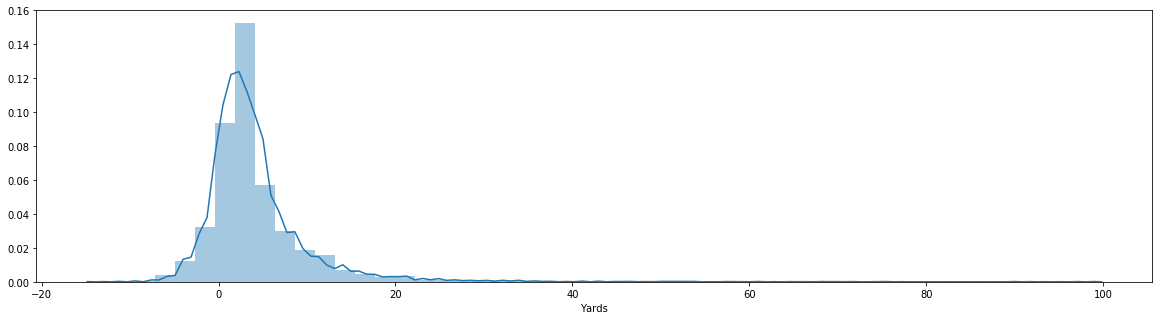

In [7]:
plt.figure(figsize=(20,5))
sns.distplot(train_df["Yards"])